In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
# Load & Explore Dataset
import pandas as pd
from IPython.display import display

# Load dataset (Ensure correct encoding)
data = pd.read_csv('car_purchasing.csv', encoding='ISO-8859-1')

# Display first few rows
print("Dataset Preview:")
display(data.head())

# Check dataset info
print("\nDataset Information:")
display(data.info())

Dataset Preview:


,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer name        500 non-null    object 
 1   customer e-mail      500 non-null    object 
 2   country              500 non-null    object 
 3   gender               500 non-null    int64  
 4   age                  500 non-null    float64
 5   annual Salary        500 non-null    float64
 6   credit card debt     500 non-null    float64
 7   net worth            500 non-null    float64
 8   car purchase amount  500 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 35.3+ KB


None

In [3]:
# Drop irrelevant columns
data = data.drop(columns=["customer name", "customer e-mail", "country"], errors='ignore')
display(data.head())

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


In [4]:
# Check missing values
print("\nMissing Values Count:")
print(data.isnull().sum())


Missing Values Count:
gender                 0
age                    0
annual Salary          0
credit card debt       0
net worth              0
car purchase amount    0
dtype: int64


In [5]:
# Generate synthetic data for additional features
data["Advertising Spend"] = np.random.uniform(500, 5000, data.shape[0])
data["Promotions"] = np.random.randint(0, 5, data.shape[0])
data["Customer Segment"] = np.random.choice(["Budget", "Standard", "Premium", "Luxury"], data.shape[0])
display(data.head())

,gender,age,annual Salary,credit card debt,net worth,car purchase amount,Advertising Spend,Promotions,Customer Segment
0,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877,2185.430535,0,Premium
1,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566,4778.214379,0,Standard
2,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921,3793.972738,0,Premium
3,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313,3193.963179,4,Standard
4,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248,1202.083882,3,Premium


In [6]:
# Outlier Removal using IQR
Q1 = data["car purchase amount"].quantile(0.25)
Q3 = data["car purchase amount"].quantile(0.75)
IQR = Q3 - Q1
data = data[(data["car purchase amount"] >= Q1 - 1.5 * IQR) & (data["car purchase amount"] <= Q3 + 1.5 * IQR)]
data = data.reset_index(drop=True)

In [7]:
# One-hot encode categorical features
categorical_cols = ["Customer Segment"]
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_categories = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical column and merge
data_processed = pd.concat([data.drop(columns=categorical_cols).reset_index(drop=True), encoded_df], axis=1)

# Check for NaN values
data_processed.fillna(0, inplace=True)

# Display processed data
data_processed.head()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount,Advertising Spend,Promotions,Customer Segment_Luxury,Customer Segment_Premium,Customer Segment_Standard
0,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877,2185.430535,0,0.0,1.0,0.0
1,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566,4778.214379,0,0.0,0.0,1.0
2,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921,3793.972738,0,0.0,1.0,0.0
3,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313,3193.963179,4,0.0,0.0,1.0
4,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248,1202.083882,3,0.0,1.0,0.0


In [8]:
# Define features (X) and target (y)
X = data_processed.drop(columns=["car purchase amount"], errors='ignore')
y = data_processed["car purchase amount"].values.reshape(-1, 1)

# Display the shapes of X and Y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (495, 10)
Shape of y: (495, 1)


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Feature scaling (ensure correct transformation)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)  # Only fit on training data
y_test_scaled = scaler_y.transform(y_test)

In [11]:
# Define neural network model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(512),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128),
    LeakyReLU(negative_slope=0.1),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64),
    LeakyReLU(negative_slope=0.1),
    Dense(1)
])
# Increased Learning Rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,761 (710.00 KB)

 Trainable params: 179,969 (703.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [12]:
# Increased Early Stopping Patience
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train model
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled),
                    epochs=500, batch_size=64, callbacks=[early_stopping], verbose=1)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 1.3178 - val_loss: 0.1679
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5167 - val_loss: 0.1305
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4456 - val_loss: 0.1167
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4289 - val_loss: 0.1039
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2407 - val_loss: 0.0929
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1843 - val_loss: 0.0825
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1687 - val_loss: 0.0710
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1812 - val_loss: 0.0656
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1657 - val_loss: 0.0543
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1671 - val_loss: 0.0498
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1388 - val_loss: 0.0437
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1172 - val_l

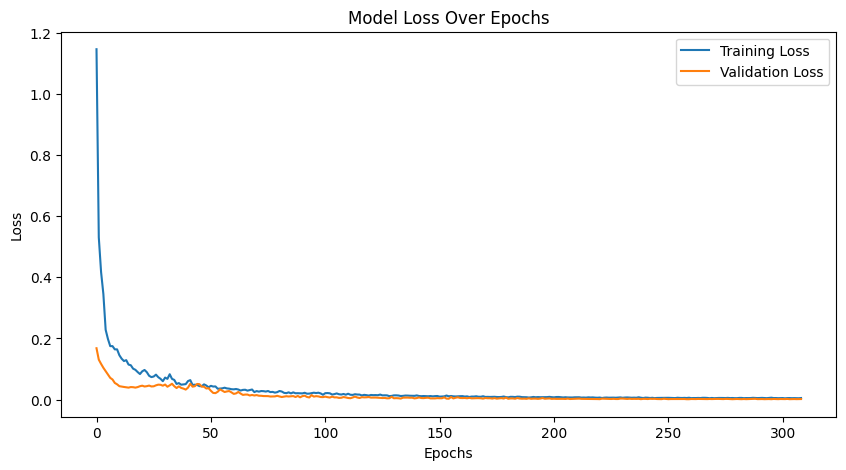

In [13]:
# Plot loss vs epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()

In [14]:
# Predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


In [15]:
# Evaluate the model
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 1329.5076689015145
R2 Score: 0.9759168087450423


In [16]:
# Compare predicted vs actual values for first 10 test samples
comparison_df = pd.DataFrame({
    "Actual Amount": y_test_actual.flatten(),
    "Predicted Amount": y_pred.flatten()
})

print(comparison_df.head(10))  # Display the first 10 comparisons

   Actual Amount  Predicted Amount
0    38243.06228      33640.085938
1    52991.52667      51037.164062
2    35781.16156      35650.191406
3    64545.16339      62486.472656
4    30826.10903      30469.091797
5    45805.30588      46714.601562
6    38172.83602      39012.902344
7    47380.91224      46841.113281
8    41137.89459      38872.640625
9    38189.50601      38146.113281


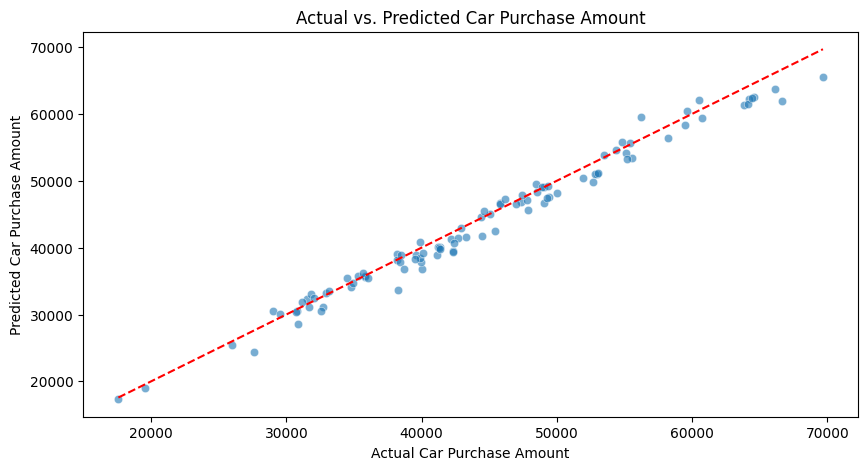

In [17]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test_actual.flatten(), y=y_pred.flatten(), alpha=0.6)
plt.xlabel("Actual Car Purchase Amount")
plt.ylabel("Predicted Car Purchase Amount")
plt.title("Actual vs. Predicted Car Purchase Amount")
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], linestyle='--', color='red')  # Ideal fit line
plt.show()

In [18]:
# Function to predict car purchase amount
def predict_car_price(sample_input):
    sample_df = pd.DataFrame([sample_input], columns=X.columns)  # Ensure feature names match
    sample_input_scaled = scaler_X.transform(sample_df)
    predicted_scaled = model.predict(sample_input_scaled)
    predicted_price = scaler_y.inverse_transform(predicted_scaled)
    return predicted_price[0][0]

# Example usage
sample_data = X_test.iloc[0].values  # Taking the first test sample as input
predicted_amount = predict_car_price(sample_data)
print(f"Predicted Car Purchase Amount: {predicted_amount}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Predicted Car Purchase Amount: 33640.09375
